In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据

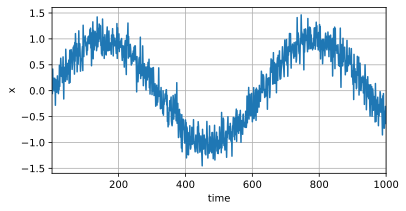

In [2]:
T = 1000  # 总共产生1000个时间点
time = torch.arange(1, T + 1, dtype=torch.float32) # [1,2,..1000]

x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的特征－标签对。假设：我们Xt时刻的数据与前tau个数据相关。因此，前tau个数据的历史纪录是不足的，一种简单的方式就是放弃使用前tau个数据训练；另一个方法是用零填充历史记录。

In [3]:
tau = 4 # x1,x2,x3,x4的历史记录不足，不使用其进行训练
features = torch.zeros((T - tau, tau)) # T - tau个样本，tau个特征
# 按列填充好特征矩阵
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
# 填充好标签
labels = x[tau:].reshape((-1, 1))

# 加载数据集，仅使用前600个样本进行训练
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [4]:
# 初始化网络的权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
# 构建一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备训练模型了。实现下面的训练代码的方式与前面几节中的循环训练基本相同。

In [5]:
def train(net, train_iter, loss, num_epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
            
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.056985
epoch 2, loss: 0.049431
epoch 3, loss: 0.048080
epoch 4, loss: 0.047225
epoch 5, loss: 0.047634


## 预测
首先是检查模型预测下一个时间步的能力， 也就是单步预测。单步预测顾名思义只预测下一个时间点的值，预测使用的特征都是真实值

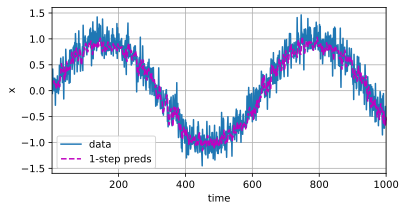

In [6]:
onestep_preds = net(features) # 预测时使用的特征都是原始数据
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

单步预测效果不错。在测试样本（对time = 604到1000的预测）上表现依然较好

多步预测：假设我们要用前4个预测后4个，那操作就是先用前4个预测出第5个，再用第2 - 5个预测第6个，以此类推。也就是说我们必须使用到我们自己的预测结果来进行下一步预测。

多步预测是通过仅有的数据，预测之后多个时间点的值，且对当前时间点的预测会使用到上一个时间点的预测结果，由于每一次预测都有误差，误差不断累计，使得很难预测多步

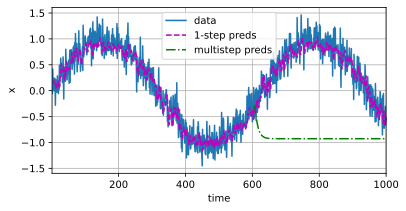

In [7]:
multistep_preds = torch.zeros(T)
# 前604个填入真实值
multistep_preds[: n_train + tau] = x[: n_train + tau]

for i in range(n_train + tau, T):
    multistep_preds[i] = net( # 预测的特征含有也是预测的值
            multistep_preds[i - tau:i].reshape((1, -1))
        )

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

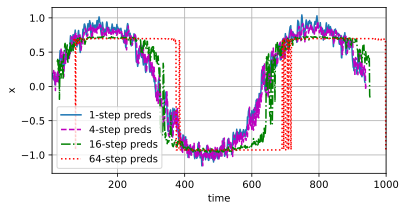

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
# 按列填充观察到的特征，通过这些特征预测
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。模型努力的方向：尽可能远的预测未来